In [107]:
import pyro
from pyro import distributions as dist
import pyro.distributions.constraints as constraints
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
import pyro.contrib.gp as gp
from sklearn.datasets import fetch_olivetti_faces
from tqdm.autonotebook import tqdm
from sklearn.decomposition import NMF

In [108]:
pyro.clear_param_store()

In [109]:
x_train, y_train = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=97)


In [110]:
Y = (x_train.T)*255
Y = Y.astype(int)
Y = torch.tensor(Y)

In [111]:
idx = torch.linspace(-5, 5, 64, dtype=torch.float)

X_coordinates = torch.cartesian_prod(idx, idx)

model = NMF(10)
F_ = torch.tensor(model.fit_transform(Y).T, dtype=torch.float)
W_ = torch.tensor(model.components_.T, dtype=torch.float)

In [112]:
N, D = Y.shape
L = 10

U_len = 20

idz = torch.linspace(-5, 5, U_len, dtype=torch.float)



def model(data):

    U_m = pyro.param("U_m", torch.zeros(L, U_len**2))
    F_m = pyro.param("F_m", F_.clone())
    kernel_lengthscale = pyro.param("kernel_lengthscale", torch.tensor([1]), constraint=constraints.positive)
    kernel_variance = pyro.param("kernel_variance", torch.tensor([1]), constraint=constraints.positive)
    noise= pyro.param("noise", torch.ones([1]), constraint=constraints.positive)
    


    Z_coordinates = pyro.param("Z", torch.cartesian_prod(idz, idz))
    kernel = gp.kernels.Matern32(
input_dim=2, variance=kernel_variance, lengthscale=kernel_lengthscale)
    Kzz = kernel.forward(Z_coordinates)+ noise.expand(U_len**2).diag()
    Kxx = kernel.forward(X_coordinates)+ noise.expand(N).diag()
    Kxz = kernel.forward(X_coordinates, Z_coordinates)

    LKzz = torch.linalg.cholesky(Kzz)  #Kzz = (L)(L^T)
    Kzz_inv = torch.cholesky_inverse(LKzz) #Kzz^-1 = (L^-T)(L^-1)
    LKzz_inv = (LKzz.T)@Kzz_inv  #L^-1

    
    W = pyro.param("W", W_.clone(), constraint=constraints.positive)

    with pyro.plate("U_plate_L", L):
        U = pyro.sample("U", dist.MultivariateNormal(U_m, scale_tril=LKzz))
    
    mu = F_m + (U-U_m)@Kzz_inv@ (Kxz.T)

    LQxx = Kxz @ (LKzz_inv.T)
    Qxx = LQxx @ (LQxx.T)
    

    with pyro.plate("F_plate_L", L):
        F = pyro.sample("F", dist.LowRankMultivariateNormal(mu, cov_factor=LQxx, cov_diag=torch.diag(Kxx-Qxx)))


    F_exp = torch.exp(F.T)
    v = pyro.param("v", torch.ones(N,1), constraint=constraints.positive)
    mu = F_exp@W.T

    with pyro.plate("Y_plate_N", N):
        Y = pyro.sample("Y", dist.Poisson(v*mu).to_event(1), obs=data)

    return W, F, kernel

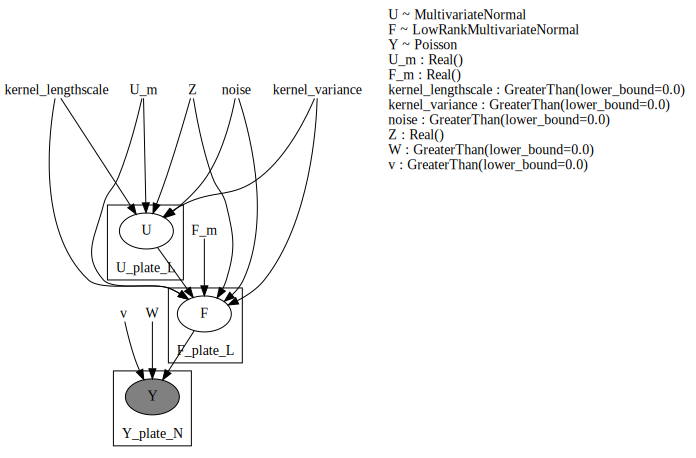

In [113]:
data = torch.ones(N, D)
pyro.render_model(model, model_args=(data,), render_params=True, render_distributions=True)

In [124]:
# def guide(data):


#     params = pyro.get_param_store()
#     U_m = params["U_m"]
#     F_m = params["F_m"]
#     Z_coordinates = params["Z"]
#     kernel_lengthscale = params["kernel_lengthscale"]
#     kernel_variance = params["kernel_variance"]
#     noise= params["noise"]



    
#     kernel = gp.kernels.Matern32(
# input_dim=2, variance=kernel_variance, lengthscale=kernel_lengthscale)
#     Kzz = kernel.forward(Z_coordinates)+ noise.expand(U_len**2).diag()
#     Kxx = kernel.forward(X_coordinates)+ noise.expand(N).diag()
#     Kxz = kernel.forward(X_coordinates, Z_coordinates)

#     LKzz = torch.linalg.cholesky(Kzz)  #Kzz = (L)(L^T)
#     Kzz_inv = torch.cholesky_inverse(LKzz) #Kzz^-1 = (L^-T)(L^-1)
#     LKzz_inv = (LKzz.T)@Kzz_inv  #L^-1


#     mean_q = pyro.param("mean_q", torch.zeros((L, U_len**2)))
#     sigma_q = pyro.param("sigma_q", torch.ones((L, U_len**2)),
#                         constraint=constraints.positive)
    

#     with pyro.plate("U_plate_L", L):
#         U = pyro.sample("U", dist.Normal(mean_q, sigma_q).to_event(1))



#     mu = F_m + (mean_q - U_m)@Kzz_inv@(Kxz.T)

#     diff = Kzz-torch.diag_embed(sigma_q)

#     alpha = Kxz @ Kzz_inv

#     midK = diff@(alpha.T)

#     K = Kxx - torch.transpose(midK, 1, 2) @ (alpha.T)
    

#     with pyro.plate("F_plate_L", L):
#         F = pyro.sample("F", dist.MultivariateNormal(mu, scale_tril=torch.linalg.cholesky(K)))


#     return mean_q, sigma_q, mu

In [128]:
# def guide(data):


#     params = pyro.get_param_store()
#     Z_coordinates = params["Z"]
#     kernel_lengthscale = params["kernel_lengthscale"]
#     kernel_variance = params["kernel_variance"]
#     noise= params["noise"]


#     kernel = gp.kernels.Matern32(
# input_dim=2, variance=kernel_variance, lengthscale=kernel_lengthscale)
#     Kzz = kernel.forward(Z_coordinates)+ noise.expand(U_len**2).diag()

#     LKzz = torch.linalg.cholesky(Kzz)  #Kzz = (L)(L^T)


#     mean_q = pyro.param("mean_q", torch.zeros((L, U_len**2)))
    

#     with pyro.plate("U_plate_L", L):
#         U = pyro.sample("U", dist.MultivariateNormal(mean_q, scale_tril=LKzz))
    


#     return mean_q

In [129]:
def guide(data):


    params = pyro.get_param_store()
    U_m = params["U_m"]
    F_m = params["F_m"]
    Z_coordinates = params["Z"]
    kernel_lengthscale = params["kernel_lengthscale"]
    kernel_variance = params["kernel_variance"]
    noise= params["noise"]



    
    kernel = gp.kernels.Matern32(
input_dim=2, variance=kernel_variance, lengthscale=kernel_lengthscale)
    Kzz = kernel.forward(Z_coordinates)+ noise.expand(U_len**2).diag()
    Kxx = kernel.forward(X_coordinates)+ noise.expand(N).diag()
    Kxz = kernel.forward(X_coordinates, Z_coordinates)

    LKzz = torch.linalg.cholesky(Kzz)  #Kzz = (L)(L^T)
    Kzz_inv = torch.cholesky_inverse(LKzz) #Kzz^-1 = (L^-T)(L^-1)
    LKzz_inv = (LKzz.T)@Kzz_inv  #L^-1


    mean_q = pyro.param("mean_q", torch.zeros((L, U_len**2)))
    

    with pyro.plate("U_plate_L", L):
        U = pyro.sample("U", dist.MultivariateNormal(mean_q, scale_tril=LKzz))



    mu = F_m + (U-mean_q)@Kzz_inv@ (Kxz.T)

    LQxx = Kxz @ (LKzz_inv.T)
    Qxx = LQxx @ (LQxx.T)
    

    with pyro.plate("F_plate_L", L):
        F = pyro.sample("F", dist.LowRankMultivariateNormal(mu, cov_factor=LQxx, cov_diag=torch.diag(Kxx-Qxx)))


    return mean_q, 0, mu

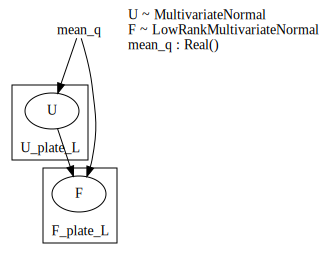

In [130]:
pyro.render_model(guide, model_args=(data,), render_params=True, render_distributions=True)

In [120]:
adam_params = {"lr": 1e-2, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

In [121]:
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [123]:
# do gradient steps
losses = []
for step in tqdm(range(1500)):
    elbo = svi.step(Y)
    losses.append(elbo)

  0%|          | 0/1500 [00:00<?, ?it/s]

KeyboardInterrupt: 

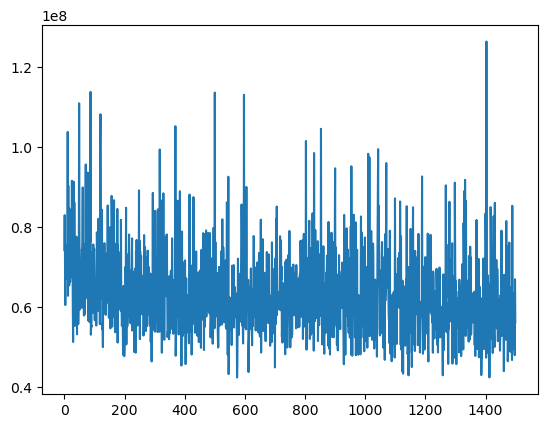

In [ ]:
plt.plot(losses)

In [ ]:
serving_model = infer_discrete(model, first_available_dim=-1)
W, F, kernel = serving_model(Y)

In [ ]:
_, _, qF = guide(Y)
qF = qF.T

f = (1/(qF.exp()).sum(axis=0)).diag()

F_post = qF.exp() @ f

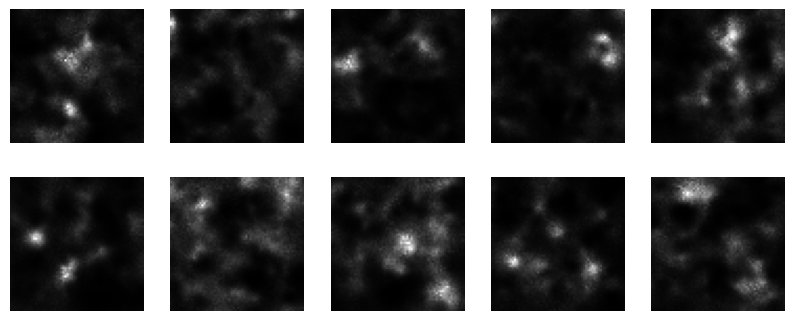

In [ ]:
plt.figure(figsize=(10, (L//5) * 2))
for i in range(L):
    plt.subplot(L//5, 5, i+1)
    loading = F_post[:, i].detach().cpu().numpy()
    plt.imshow(loading.reshape(64, 64), cmap='gray')
    plt.axis('off')

In [ ]:
params = pyro.get_param_store()
Z_coordinates = params["Z"].detach().numpy()

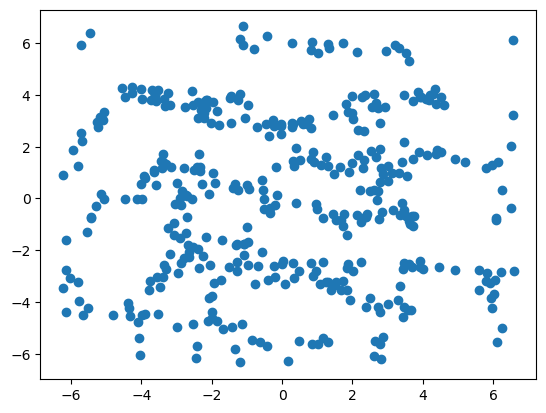

In [ ]:
plt.scatter(Z_coordinates[:,0], Z_coordinates[:,1])